<a href="https://colab.research.google.com/github/FredLongo/Cancer_Detection_Project/blob/main/segmentation_PC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Segmentation Performs the following**
   The purpose of the segmentation  is to find regions of intrest (ROI) in the MRI scans.  By doing this we get lists of nodules areas to be evaluated.

*   Preps Environment
*   Preprocess Data
*   Preps the data for training
*   Builds the Model
*   Train the model
*   Save the best model off to be used later

---

---
Prep Environment

---




In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
#import torch

import random
# import cell_magic_wand as cmw



My data is stored on my Good Drive so it needs to be Connected

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/PCAI_Project

/content/drive/MyDrive/PCAI_Project


---
Preprocess Data

---
This Section Creates the lungs_roi and nodule_masks for trainng.
This only needs to be done once and then can be skipped when training models latter.

If I want to redo the building of the lung_roi and nuldule_mask used for training I can delet them.  Of if I want to zip it all up

In [ ]:
#Clean up mess from last run
#!rm -r ProcessedData/lungs_roi/*
#!rm -r ProcessedData/nodule_mask/*

rm: cannot remove 'ProcessedData/lungs_roi/*': No such file or directory
rm: cannot remove 'ProcessedData/nodule_mask/*': No such file or directory


In [ ]:
root = "subset0/"
target_root = "ProcessedData/"

In [ ]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)                 # indexes are z,y,x
    origin = np.array(list(mhdimage.GetOrigin()))   # x,y,z  Origin in world coordinates (mm)
    space = np.array(list(mhdimage.GetSpacing()))   # spacing of voxels in world coor. (mm)
    return ct_scan, origin, space

In [ ]:
ls

 annotations.csv             FPRDataset/
 candidates_1Non.txt         FPRProcessedData/
 candidates_1.txt           'lung cancer detection_old.ipynb'
 candidates.csv              model.h5
 checkpoint-001-0.000.hdf5   ProcessedData/
 checkpoint-001-0.217.hdf5   segmentation_old.ipynb
 checkpoint-002-0.202.hdf5   subset0/
 checkpoint-003-0.189.hdf5   testX.npy
 checkpoint_model.h5         testY.npy
'classifier CNN_old.ipynb'   trainX.npy
 drive/                      trainY.npy
 FPR_classifier_model.h5     UNet_model.h5


In [ ]:

file_list = glob(root+"*.mhd")
annotations_df = pd.read_csv("annotations.csv")
print("Files Count:",len(file_list))
print("DF Count:",len(annotations_df))
annotations_df.head()

Files Count: 89
DF Count: 1186


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


(array([15., 32., 55., 87., 94., 90., 79., 79., 75., 50., 51., 26., 41.,
        29., 24., 27., 18., 25., 16., 15., 10., 18., 10.,  9., 14., 11.,
        13.,  9.,  9.,  7., 10.,  7.,  6.,  8.,  3.,  8.,  5.,  7., 10.,
         9.,  2.,  6.,  6.,  4.,  2.,  5.,  3.,  4.,  2.,  5.,  5.,  3.,
         6.,  2.,  2.,  2.,  3.,  2.,  0.,  3.,  1.,  1.,  1.,  0.,  0.,
         2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.]),
 array([ 3.2534432 ,  3.61615053,  3.97885787,  4.34156521,  4.70427255,
         5.06697989,  5.42968723,  5.79239456,  6.1551019 ,  6.51780924,
         6.88051658,  7.24322392,  7.60593125,  7.96863859,  8.33134593,
         8.69405327,  9.05676061,  9.41946794,  9.78217528, 10.14488262,
        10.50758996, 10.8702973 , 11.23300464, 11.59571197, 11.95841931,
        12.32112665, 12.68383399, 13.04654133, 13.40924866, 13.771956  ,
        14.13466334, 14.49737068, 14.86007802, 15.22278536, 15.58549269,
        15.94820003, 16.3109073

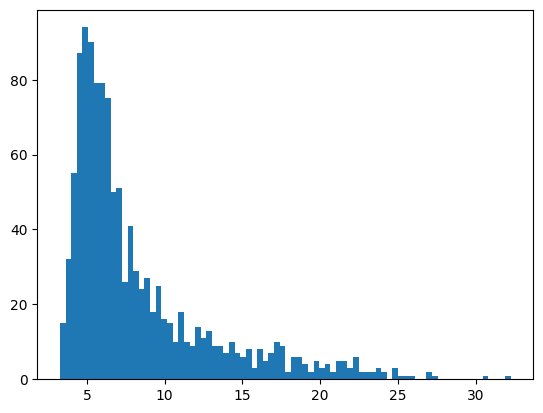

In [ ]:
# displaying annotation size distribution for nodul diameter
d = annotations_df['diameter_mm'].values
plt.hist(d, bins=80)

In [ ]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [ ]:
# This maps the annotation to the file names, pulling all the data into a single data frame.

annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
annotations_df = annotations_df[annotations_df['diameter_mm']>=4]  # Excluding nodules with diameter less than 4mm
print(len(annotations_df))

108


In [ ]:
annotations_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,filename
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081...
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090...
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090...
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111...
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1241...


In [ ]:
# Help Draw shape of lung images
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (int(center[0]),int(center[1])), diam//2, 255, -1)
    return mask

In [ ]:
def mark_done(path):
    with open(path[:-3]+'done2', 'a'):
        pass


In [ ]:
def is_done(path):
    return os.path.exists(path[:-3]+'done2')

In [ ]:
#i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values)))

#np.unique(annotations_df['filename'].values)

#annotations_df = annotations_df[annotations_df['filename'] != 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd']
#annotations_df = annotations_df[annotations_df['filename'] != 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd']
#annotations_df = annotations_df[annotations_df['filename'] != 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd']
#annotations_df = annotations_df[annotations_df['filename'] != 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd']

In [ ]:
annotations_df.shape[0]

108

In [ ]:
## This iteratates over all the files gets the x y z voxal of the image to be evaluated using Annotation File


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image

# Iterating over all the files in the subset
for i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):             ### Loop over all images
    annotations = annotations_df[annotations_df["filename"]==file]
    done_flag = is_done(file)

    print('Is Done Flag =', done_flag, '   file:',file)
    if os.path.exists(file) and not done_flag:
        try:
          ct, origin, space = load_mhd(file)                                             ### Loading the CT scan
          num_z, height, width = ct.shape
          ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)                     ### Normalizing the CT scan (improve contrast)
          for idx, row in annotations.iterrows():
              node_x = int(row["coordX"])         # X coordinate of the nodule
              node_y = int(row["coordY"])         # Y coordinate of the nodule
              node_z = int(row["coordZ"])         # Z coordinate of the nodule
              diam = int(row["diameter_mm"])      # Diameter of the nodule

              center = np.array([node_x, node_y, node_z])   # nodule center (x,y,z)
              v_center = np.rint((center-origin)/space)   # nodule center in voxel space (still x,y,z ordering)

              img_norm = ct_norm[int(v_center[2]),:,:]        # a slice of the CT scan containing the nodule
              img_norm = cv2.resize(img_norm, (512,512))      # Resizing the slice to 512x512
              img_norm_improved = clahe.apply(img_norm.astype(np.uint8))  # Applying CLAHE filter to the image

              ################################################################################################
              v_diam = int(diam/space[0])+5       # Diameter of the nodule in voxel space
              mask = make_mask(img_norm, v_center, v_diam)                      ### Creating a mask of the nodule
              if v_diam>18:          # If the nodule is too big, we will also take neighboring slices
                  img_norm2 = ct_norm[(int(v_center[2])-1),:,:]
                  img_norm2 = cv2.resize(img_norm2, (512,512))
                  img_norm2_improved = clahe.apply(img_norm2.astype(np.uint8))
                  mask2 = make_mask(img_norm2, v_center, v_diam-1)

                  img_norm3 = ct_norm[(int(v_center[2])+1),:,:]
                  img_norm3 = cv2.resize(img_norm3, (512,512))
                  img_norm3_improved = clahe.apply(img_norm3.astype(np.uint8))
                  mask3 = make_mask(img_norm3, v_center, v_diam-1)
              ################################################################################################
                                                                                ### Calcualte and extract the threshold value
              # Calculating the threshold value for extracting the nodule mask using binary thresholding
              centeral_area = img_norm[100:400, 100:400]
              kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
              centroids = sorted(kmeans.cluster_centers_.flatten())
              threshold = np.mean(centroids)

              ################################################################################################
              # Extracting the nodule using binary thresholding
              mask = cv2.bitwise_and(img_norm, img_norm, mask=mask)
              _, mask = cv2.threshold(mask, threshold-5, 255, cv2.THRESH_BINARY)
              if v_diam>18:
                  mask2 = cv2.bitwise_and(img_norm2, img_norm2, mask=mask2)
                  _, mask2 = cv2.threshold(mask2, threshold-5, 255, cv2.THRESH_BINARY)

                  mask3 = cv2.bitwise_and(img_norm3, img_norm3, mask=mask3)
                  _, mask3 = cv2.threshold(mask3, threshold-5, 255, cv2.THRESH_BINARY)
              ################################################################################################

              # Steps to segment the lungs from CT scan slices
              ret, lung_roi = cv2.threshold(img_norm, threshold, 255, cv2.THRESH_BINARY_INV)
              lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))       ### remove small outliers and separate any connected tissue
              lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))    ### Dilates the mask to regain lung shape after eroding
              lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))       ### Erodes again with a medium-sized 8x8 kernel to smooth the lung shape

              labels = measure.label(lung_roi)        # Labelling different regions in the image
              regions = measure.regionprops(labels)   # Extracting the properties of the regions
              good_labels = []
              for prop in regions:        # Filtering the regions that are not too close to the edges
                  B = prop.bbox           # Regions that are too close to the edges are outside regions of lungs
                  if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
                      good_labels.append(prop.label)
              lung_roi_mask = np.zeros_like(labels)
              for N in good_labels:
                  lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

              # Steps to get proper segmentation of the lungs without noise and holes
              contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
              external_contours = np.zeros(lung_roi_mask.shape)
              for i in range(len(contours)):
                  if hirearchy[0][i][3] == -1:  #External Contours
                      area = cv2.contourArea(contours[i])
                      if area>518.0:
                          cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
              external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))

              external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
              external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
              external_contours = cv2.bitwise_not(external_contours)
              external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
              external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))

              img_norm_improved = img_norm_improved.astype(np.uint8)
              external_contours = external_contours.astype(np.uint8)      # Final segmentated lungs mask
              extracted_lungs = cv2.bitwise_and(img_norm_improved, img_norm_improved, mask=external_contours)

              #################################################################################################
              if v_diam>18:
                  img_norm2_improved = img_norm2_improved.astype(np.uint8)
                  extracted_lungs2 = cv2.bitwise_and(img_norm2_improved, img_norm2_improved, mask=external_contours)
                  mask2 = mask2.astype(np.uint8)
                  np.save(os.path.join(target_root+"nodule_mask/", f"masks_{i}_{idx}_2.npy"), mask2)
                  np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{i}_{idx}_2.npy"), extracted_lungs2)

                  img_norm3_improved = img_norm3_improved.astype(np.uint8)
                  extracted_lungs3 = cv2.bitwise_and(img_norm3_improved, img_norm3_improved, mask=external_contours)
                  mask3 = mask3.astype(np.uint8)
                  np.save(os.path.join(target_root+"nodule_mask/", f"masks_{i}_{idx}_3.npy"), mask3)
                  print("Saved > 18: "+ target_root+"nodule_mask/", f"masks_{i}_{idx}_3.npy")
                  np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{i}_{idx}_3.npy"), extracted_lungs3)
                  print("Saved > 18: "+ target_root+"lungs_roi/", f"lungs_{i}_{idx}_3.npy")
              #################################################################################################

              mask = mask.astype(np.uint8)
              np.save(os.path.join(target_root+"nodule_mask/", f"masks_{i}_{idx}.npy"), mask)            # Saving the nodule mask
              print("Saved     : "+ target_root+"nodule_mask/", f"masks_{i}_{idx}.npy")
              np.save(os.path.join(target_root+"lungs_roi/", f"lungs_{i}_{idx}.npy"), extracted_lungs)
              print("Saved     : "+ target_root+"lungs_roi/", f"lungs_{i}_{idx}.npy")
        except RuntimeError as error:
          print("An error occurred while trying to read the image in file:",file )
          print(str(error))




0it [00:00, ?it/s]

Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_23.npy


1it [00:07,  7.93s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_23.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_13_25_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_13_25_3.npy
Saved     : ProcessedData/nodule_mask/ masks_13_25.npy
Saved     : ProcessedData/lungs_roi/ lungs_13_25.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_11_26.npy


2it [00:18,  9.34s/it]

Saved     : ProcessedData/lungs_roi/ lungs_11_26.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_28.npy


3it [00:26,  9.05s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_28.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_86.npy


4it [00:32,  7.83s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_86.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_98.npy


5it [00:42,  8.40s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_98.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_103_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_103_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_103.npy


6it [00:49,  7.98s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_103.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_110.npy


7it [00:56,  7.82s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_110.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_11_117.npy


8it [01:02,  7.07s/it]

Saved     : ProcessedData/lungs_roi/ lungs_11_117.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_129.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_129.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_130.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_130.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_131.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_131.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_132.npy


9it [01:12,  7.92s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_132.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_135_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_135_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_135.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_135.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_136_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_136_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_136.npy


10it [01:26,  9.79s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_136.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_6_139.npy


11it [01:32,  8.81s/it]

Saved     : ProcessedData/lungs_roi/ lungs_6_139.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_9_144_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_9_144_3.npy
Saved     : ProcessedData/nodule_mask/ masks_9_144.npy


12it [01:44,  9.73s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_144.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_149.npy


13it [01:50,  8.68s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_149.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_199_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_199_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_199.npy


14it [02:00,  8.95s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_199.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_9_335_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_9_335_3.npy
Saved     : ProcessedData/nodule_mask/ masks_9_335.npy
Saved     : ProcessedData/lungs_roi/ lungs_9_335.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_336_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_336_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_336.npy


15it [02:12,  9.94s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_336.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_1_344.npy
Saved     : ProcessedData/lungs_roi/ lungs_1_344.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_345.npy


16it [02:18,  8.64s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_345.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_347.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_347.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_348.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_348.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_349.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_349.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_350.npy


17it [02:30,  9.58s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_350.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_367.npy


18it [02:35,  8.28s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_367.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_420_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_420_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_420.npy


19it [02:42,  7.88s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_420.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_454_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_454_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_454.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_454.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_455.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_455.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_456.npy


20it [02:53,  8.95s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_456.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_490_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_490_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_490.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_490.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_491.npy


21it [03:03,  9.31s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_491.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_1_506_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_1_506_3.npy
Saved     : ProcessedData/nodule_mask/ masks_1_506.npy
Saved     : ProcessedData/lungs_roi/ lungs_1_506.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_507.npy


22it [03:14,  9.70s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_507.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_536_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_536_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_536.npy


23it [03:22,  9.15s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_536.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_580.npy


24it [03:29,  8.54s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_580.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_620.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_620.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_621.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_621.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_622_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_622_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_622.npy


25it [03:43, 10.11s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_622.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_1_630.npy


26it [03:50,  9.38s/it]

Saved     : ProcessedData/lungs_roi/ lungs_1_630.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_705.npy


27it [03:56,  8.31s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_705.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_732.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_732.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_733.npy


28it [04:03,  7.83s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_733.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_748.npy


29it [04:11,  8.03s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_748.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_783.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_783.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_784.npy


30it [04:20,  8.15s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_784.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_789.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_789.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_790.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_790.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_791.npy


31it [04:29,  8.34s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_791.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_792.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_792.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_793.npy


32it [04:36,  8.15s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_793.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_794.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_794.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_795.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_795.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_13_796.npy
Saved     : ProcessedData/lungs_roi/ lungs_13_796.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_798.npy


33it [04:46,  8.66s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_798.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_836.npy


34it [04:53,  8.12s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_836.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_838.npy
Saved     : ProcessedData/lungs_roi/ lungs_9_838.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_839.npy


35it [05:00,  7.73s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_839.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_858.npy


36it [05:05,  7.06s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_858.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_871_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_871_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_871.npy


37it [05:13,  7.27s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_871.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_872.npy


38it [05:18,  6.45s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_872.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_873_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_873_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_873.npy


39it [05:28,  7.50s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_873.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_882_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_882_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_882.npy


40it [05:38,  8.32s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_882.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_889.npy


41it [05:43,  7.23s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_889.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_897.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_897.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_898.npy


42it [05:50,  7.20s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_898.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_935.npy


43it [05:54,  6.24s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_935.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_937_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_937_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_937.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_937.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_938.npy
Saved     : ProcessedData/lungs_roi/ lungs_9_938.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_939.npy


44it [06:06,  8.03s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_939.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_966.npy


45it [06:10,  6.89s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_966.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_970.npy


46it [06:16,  6.43s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_970.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_978_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_978_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_978.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_978.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_979.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_979.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_980.npy


47it [06:33,  9.65s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_980.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_987_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_987_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_987.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_987.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_11_988.npy


48it [06:42,  9.47s/it]

Saved     : ProcessedData/lungs_roi/ lungs_11_988.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_1011_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_1011_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_1011.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_1011.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_1012.npy
Saved     : ProcessedData/lungs_roi/ lungs_9_1012.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_1013_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_1013_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_1013.npy


49it [06:57, 11.22s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_1013.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd


50it [06:58,  8.07s/it]

An error occurred while trying to read the image in file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/Meta/src/itkMetaImageIO.cxx:483:
ITK ERROR: MetaImageIO(0x5cda1375a7a0): File cannot be read: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd for reading.
Reason: No such file or directory
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_1017_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_1017_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_1017.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_1017.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_5_1018_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_5_1018_3.npy
Saved     : ProcessedData/nodule_mask/ masks_5_1018.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_1018.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_1019.npy


51it [07:17, 11.54s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_1019.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_1020.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_1020.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_1021.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_1021.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_1022.npy


52it [07:27, 10.90s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_1022.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd


53it [07:27,  7.82s/it]

An error occurred while trying to read the image in file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/Meta/src/itkMetaImageIO.cxx:483:
ITK ERROR: MetaImageIO(0x5cda1375a7a0): File cannot be read: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd for reading.
Reason: No such file or directory
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_1049.npy


54it [07:33,  7.11s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_1049.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_1054.npy


55it [07:39,  6.95s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_1054.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_1072_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_1072_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_1072.npy


56it [07:50,  8.11s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_1072.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_1073.npy
Saved     : ProcessedData/lungs_roi/ lungs_3_1073.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_1074.npy


57it [08:00,  8.62s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_1074.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_1084_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_1084_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_1084.npy


58it [08:08,  8.28s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_1084.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_7_1106_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_7_1106_3.npy
Saved     : ProcessedData/nodule_mask/ masks_7_1106.npy


59it [08:15,  8.18s/it]

Saved     : ProcessedData/lungs_roi/ lungs_7_1106.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_1_1108.npy
Saved     : ProcessedData/lungs_roi/ lungs_1_1108.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_1109.npy


60it [08:25,  8.52s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_1109.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_1116.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_1116.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_3_1117.npy


61it [08:31,  7.80s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_1117.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_1123.npy
Saved     : ProcessedData/lungs_roi/ lungs_9_1123.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_1124.npy
Saved     : ProcessedData/lungs_roi/ lungs_5_1124.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_5_1125.npy


62it [08:40,  8.25s/it]

Saved     : ProcessedData/lungs_roi/ lungs_5_1125.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_7_1137.npy
Saved     : ProcessedData/lungs_roi/ lungs_7_1137.npy


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_1138.npy


63it [08:48,  8.01s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_1138.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved > 18: ProcessedData/nodule_mask/ masks_3_1141_3.npy
Saved > 18: ProcessedData/lungs_roi/ lungs_3_1141_3.npy
Saved     : ProcessedData/nodule_mask/ masks_3_1141.npy


64it [08:55,  7.74s/it]

Saved     : ProcessedData/lungs_roi/ lungs_3_1141.npy
Is Done Flag = False    file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved     : ProcessedData/nodule_mask/ masks_9_1180.npy


65it [09:00,  8.31s/it]

Saved     : ProcessedData/lungs_roi/ lungs_9_1180.npy


In [ ]:

lung_names = os.listdir("ProcessedData/lungs_roi/")
random.shuffle(lung_names)

In [ ]:
n = len(lung_names)
s = int(n*.8)
train_lung_names = lung_names[:s]
test_lung_names = lung_names[s:]
print(len(train_lung_names))
print(len(test_lung_names))

129
33


In [ ]:
trainX = []
trainY = []

for lname in tqdm(train_lung_names):
  mname = lname.replace("lungs","masks")
  lung = np.load("ProcessedData/lungs_roi/"+lname)
  mask = np.load("ProcessedData/nodule_mask/"+mname)
  trainX.append(lung)
  trainY.append(mask)

trainX = np.array(trainX, dtype=np.uint8)
trainY = np.array(trainY, dtype=np.uint8)

np.save("trainX.npy", trainX)
np.save("trainY.npy", trainY)

100%|██████████| 129/129 [00:01<00:00, 121.46it/s]


In [ ]:
testX = []
testY = []

for lname in tqdm(test_lung_names):
  mname = lname.replace("lungs","masks")
  lung = np.load("ProcessedData/lungs_roi/"+lname)
  mask = np.load("ProcessedData/nodule_mask/"+mname)
  testX.append(lung)
  testY.append(mask)

testX = np.array(testX, dtype=np.uint8)
testY = np.array(testY, dtype=np.uint8)

np.save("testX.npy", testX)
np.save("testY.npy", testY)

100%|██████████| 33/33 [00:00<00:00, 141.30it/s]


---
Prep Training Data

---
This area preps the data varables to be used by the models for training

In [ ]:
trainX = np.load("trainX.npy").astype(np.float32)
trainY = np.load("trainY.npy").astype(np.float32)
testX = np.load("testX.npy").astype(np.float32)
testY = np.load("testY.npy").astype(np.float32)

In [ ]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [ ]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (129, 512, 512, 1)
trainY: (129, 512, 512, 1)
testX: (33, 512, 512, 1)
testY: (33, 512, 512, 1)


---
Build The Model

---

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

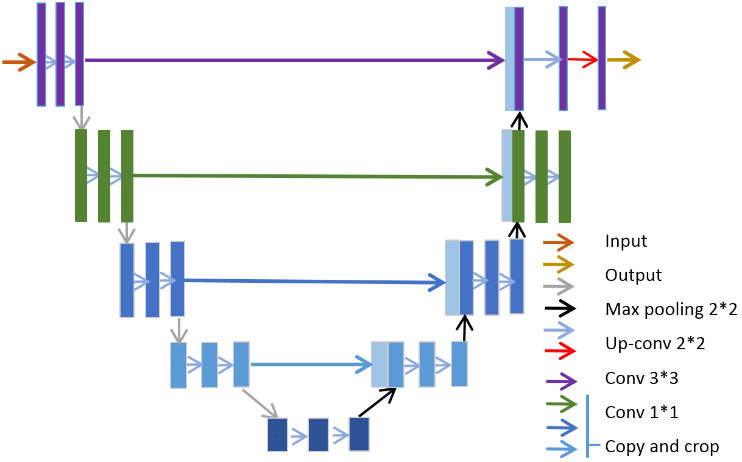![image.png](![image.png]())

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

def unet_model(input_shape=(512,512,1)):
    inputs = Input(input_shape)

    # Contracting Path                                                          ### Capertuing information from image - fetures patterns
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)                               ### Reduce by half downsample the spatial dimensions

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)                               ###Each downsampling doubles the number of filters

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up5 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)        ###upsample back to the original spatial resolution.
    up5 = concatenate([up5, conv3], axis=3)                                     ###Skip connections concatenate the corresponding contracting layers to retain spatial information that would otherwise be lost
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    outputs = Conv2D(1, (1,1), activation='sigmoid')(conv7)                     ###outputs a segmentation mask with 1 channel and sigmoid activation for pixel-wise binary classification

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create the UNet model
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
#history = model.fit(trainX, trainY, batch_size=32, epochs=1, validation_split=(testX,testY))  # gets (ResourceExhaustedError: Graph execution error:)
#history = model.fit(trainX, trainY, batch_size=2, epochs=1)  # worked
#history = model.fit(trainX, trainY, batch_size=4, epochs=1)  # worked
#history = model.fit(trainX, trainY, batch_size=8, epochs=1)  # worked
#history = model.fit(trainX, trainY, batch_size=8, epochs=10)  # worked
#history = model.fit(trainX, trainY, batch_size=8, epochs=10, validation_data=(testX,testY)) # worked
#history = model.fit(trainX, trainY, batch_size=8, epochs=20, validation_data=(testX,testY)) # worked

In [ ]:
history = model.fit(trainX, trainY, batch_size=8, epochs=20, validation_data=(testX,testY))


Epoch 1/20
17/17 [==============================] - 80s 2s/step - loss: 0.1128 - accuracy: 0.9379 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 2/20
17/17 [==============================] - 23s 1s/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 3/20
17/17 [==============================] - 24s 1s/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 4/20
17/17 [==============================] - 23s 1s/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 5/20
17/17 [==============================] - 23s 1s/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 6/20
17/17 [==============================] - 24s 1s/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9993
Epoch 7/20
17/17 [==============================] - 24s 1s/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 8/20
17/17 [==

Notes

---
Observed Facts:

* The training loss and accuracy look very good - the loss is decreasing towards 0 and the accuracy is reaching 1.0, indicating the model is fitting the training data very well.
* However, the validation loss is not improving - it is stuck around 158-160 every epoch. This means the model is overfitting the training data and not generalizing well to new data.
* The validation accuracy is very low, around 0.0390. So the model is performing very poorly on the validation set despite good training metrics.
The training loss and accuracy reach perfect values like 1e-30 and 1.0 by epoch 2. This is likely caused by overfitting with a small or improperly preprocessed dataset.

My conclution:
This model is drastically overfitting the training data and not learning generalizable patterns. The very high training accuracy but poor validation metrics are a sign of overfitting. To improve it, more training data, additional regularization techniques (dropout, etc), and hyperparameter tuning would help. But the small dataset seems to be the root issue.

In [ ]:

model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics = [dice_coef, 'binary_accuracy'])


In [ ]:
history = model.fit(trainX, trainY, batch_size=8, epochs=20, validation_data=(testX,testY))

Epoch 1/20
17/17 [==============================] - 30s 1s/step - loss: -0.0876 - dice_coef: 0.0901 - binary_accuracy: 0.9993 - val_loss: -0.1239 - val_dice_coef: 0.1582 - val_binary_accuracy: 0.9993
Epoch 2/20
17/17 [==============================] - 24s 1s/step - loss: -0.2049 - dice_coef: 0.2160 - binary_accuracy: 0.9993 - val_loss: -0.2209 - val_dice_coef: 0.2274 - val_binary_accuracy: 0.9993
Epoch 3/20
17/17 [==============================] - 23s 1s/step - loss: -0.3772 - dice_coef: 0.3948 - binary_accuracy: 0.9993 - val_loss: -0.4970 - val_dice_coef: 0.5177 - val_binary_accuracy: 0.9996
Epoch 4/20
17/17 [==============================] - 23s 1s/step - loss: -0.5744 - dice_coef: 0.5619 - binary_accuracy: 0.9994 - val_loss: -0.4333 - val_dice_coef: 0.5082 - val_binary_accuracy: 0.9989
Epoch 5/20
17/17 [==============================] - 24s 1s/step - loss: -0.4760 - dice_coef: 0.4516 - binary_accuracy: 0.9990 - val_loss: -0.2864 - val_dice_coef: 0.3615 - val_binary_accuracy: 0.9973


Notes

---
Observed Facts:
* The training loss starts negative and becomes more negative, indicating the model is optimizing the loss function.
* The training Dice coefficient improves from 0.09 to around 0.78-0.80, meaning the model is learning to segment better on the training data.
* The validation Dice also increases over time, starting at 0.15 and reaching around 0.69. So the model is generalizing reasonably well.
* The validation loss is also negative and decreasing, though not as low as the training loss - this is expected.
* The binary accuracy metrics are very high (over 0.99) throughout, indicating accurate pixel-level classification.

My Conclution: This model demonstrates decent optimization and generalization for the segmentation task. There are no signs of severe overfitting, like increasing validation loss or fluctuating validation metrics. The validation Dice plateauing around 0.69 suggests the model has reached reasonable performance, but gains may be possible with more data or model tweaks.

Compared to the previous overfit model, this one is learning much better and does not demonstrate problematic training vs validation metrics. The outputs indicate appropriate training behavior for a segmentation deep learning model.

---
Save The Model

---

In [ ]:
# save the model off.

from datetime import datetime

# Get the current date and time
now = datetime.now()

# Format the date and time
formatted_now = now.strftime("%Y%m%d_%H%M%S")

# Define your filename
filename = f"Seg_Model_{formatted_now}.h5"

model.save(filename)


